<h1 style="font-size: 50px;">Relational Automatic Learning</h1>

<div style="width: 100%; height: 1px; background-color: black; margin-top: 20px; margin-bottom: 20px"></div>

<h3>Importando librerías</h3>

In [1]:
#Abrirlo desde jupyter (no desde sage)
%reset
#!pip install networkx
#!pip install scikit-learn

import networkx as nx
import sklearn as sk

import pandas
import numpy
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


<h3>Variables de configuración (hiperparametros)</h3>

In [2]:
numberOfNodes = 156319 #Recomendado 20000 para reducir tiempos de ejecución, el maximo de nodos no repetidos es 156319

<h3>Lectura de nodos (Artists)</h3>

In [3]:
spotifyArtists = pandas.read_csv('../data/nodes.csv', header=1, low_memory=False,
                          names=['spotify_id','name','followers','popularity','genres','chart_hits'])

In [4]:
print(spotifyArtists.shape)

(156421, 6)


In [5]:
# 5 primeras filas
spotifyArtists.head(5)

,spotify_id,name,followers,popularity,genres,chart_hits
0,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"['christlicher rap', 'german hip hop']","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
1,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,[],['de (1)']
2,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"['dancehall', 'lovers rock', 'modern reggae', ...","['at (1)', 'de (1)']"
3,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"['classic swedish pop', 'norrbotten indie', 's...",['se (6)']
4,0FQMb3mVrAKlyU4H5mQOJh,Madh,26677.0,19,[],['it (2)']


<h3>Lectura de aristas (Artists feats)</h3>

In [6]:
artistsFeats = pandas.read_csv('../data/edges.csv', header=1, low_memory=False,
                          names=['id_0','id_1'])

In [7]:
print(artistsFeats.shape)

(300385, 2)


In [8]:
# 5 primeras filas
artistsFeats.head(5)

,id_0,id_1
0,0hk4xVujcyOr6USD95wcWb,7Do8se3ZoaVqUt3woqqSrD
1,38jpuy3yt3QIxQ8Fn1HTeJ,4csQIMQm6vI2A2SCVDuM2z
2,6PvcxssrQ0QaJVaBWHD07l,6UCQYrcJ6wab6gnQ89OJFh
3,2R1QrQqWuw3IjoP5dXRFjt,4mk1ScvOUkuQzzCZpT6bc0
4,0k70gnDBLPirCltbTzoxuM,5FK3qokBQYxr7ZLkr8GVFn


<h3>Subconjunto de 20.000 nodos</h3>
</br>
<div>Nos quedamos con los 20 mil primeros nodos y las aristas, que en origen y destino, apunten a dichos nodos.</div>

<h4>Subconjunto de nodos</h4>

In [9]:
subSpotifyArtists = spotifyArtists.drop_duplicates(subset='spotify_id').head(numberOfNodes) #Elimina nodos duplicados (mismo id)

print(subSpotifyArtists.shape)

subSpotifyArtists.head(5)

(156319, 6)


,spotify_id,name,followers,popularity,genres,chart_hits
0,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"['christlicher rap', 'german hip hop']","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
1,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,[],['de (1)']
2,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"['dancehall', 'lovers rock', 'modern reggae', ...","['at (1)', 'de (1)']"
3,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"['classic swedish pop', 'norrbotten indie', 's...",['se (6)']
4,0FQMb3mVrAKlyU4H5mQOJh,Madh,26677.0,19,[],['it (2)']


<h4>Subconjunto de aristas</h4>

In [10]:
subArtistsFeat = artistsFeats[artistsFeats['id_0'].isin(subSpotifyArtists['spotify_id']) & artistsFeats['id_1'].isin(subSpotifyArtists['spotify_id'])]

print(subArtistsFeat.shape)
subArtistsFeat.head(5)

(300376, 2)


,id_0,id_1
0,0hk4xVujcyOr6USD95wcWb,7Do8se3ZoaVqUt3woqqSrD
1,38jpuy3yt3QIxQ8Fn1HTeJ,4csQIMQm6vI2A2SCVDuM2z
2,6PvcxssrQ0QaJVaBWHD07l,6UCQYrcJ6wab6gnQ89OJFh
3,2R1QrQqWuw3IjoP5dXRFjt,4mk1ScvOUkuQzzCZpT6bc0
4,0k70gnDBLPirCltbTzoxuM,5FK3qokBQYxr7ZLkr8GVFn


<h3>Generando el grafo con NetworkX</h3>

In [11]:
artistsGraph = nx.Graph()

for index, row in subSpotifyArtists.iterrows():
    node_id = row['spotify_id']
    node_attributes = row.drop('spotify_id')
    artistsGraph.add_node(node_id, **node_attributes)

for index, row in subArtistsFeat.iterrows():
    node_id_0 = row['id_0']
    node_id_1 = row['id_1']
    artistsGraph.add_edge(node_id_0, node_id_1)

# Imprimimos la cantidad de nodos y aristas
print("Cantidad de nodos:", artistsGraph.number_of_nodes())
print("Cantidad de aristas:", artistsGraph.number_of_edges())

Cantidad de nodos: 156319
Cantidad de aristas: 300376


In [12]:
# Pintar el grafo completo (si hay muchos nodos tarda bastante. Muchos = mas de 3000 nodos) 
if(numberOfNodes<=3000): #Si hay más de 3000 no se visualiza porque tarda demasiado
    nx.draw(artistsGraph, node_size=1, alpha=0.9) 

    plt.show()

<h4>Añadiendo la centralidad a la información de los nodos del grafo</h4>

In [13]:
# Calcula la centralidad de grado todos nodos
degree_centrality = nx.degree_centrality(artistsGraph)

# Crea una lista de tuplas con los valores de centralidad
centrality_values = [(node, centrality) for node, centrality in degree_centrality.items()]

# Crea un DataFrame con los valores de centralidad
centrality_df = pandas.DataFrame(centrality_values, columns=['spotify_id', 'centrality'])

# Une el DataFrame de centralidad con el DataFrame subSpotifyArtists
subSpotifyArtistsCentral = subSpotifyArtists.merge(centrality_df, on='spotify_id')

# Imprime el DataFrame con la nueva columna 'centrality'
subSpotifyArtistsCentral[['spotify_id', 'centrality']].head(5)

,spotify_id,centrality
0,4lDiJcOJ2GLCK6p9q5BgfK,0.000409
1,652XIvIBNGg3C0KIGEJWit,0.000051
2,3dXC1YPbnQPsfHPVkm1ipj,0.000249
3,74terC9ol9zMo8rfzhSOiG,0.000013
4,0FQMb3mVrAKlyU4H5mQOJh,0.000051


<h4>Añadiendo el coeficiente de clustering a la información de los nodos del grafo</h4>

In [14]:
# Calcula el coeficiente de clustering de los nodos
clustering_coefficient = nx.clustering(artistsGraph)

# Crea una lista de tuplas con los valores de coeficiente de clustering
clustering_values = [(node, coefficient) for node, coefficient in clustering_coefficient.items()]

# Crea un DataFrame con los valores de coeficiente de clustering
clustering_df = pandas.DataFrame(clustering_values, columns=['spotify_id', 'clustering'])

# Une el DataFrame de coeficiente de clustering con el DataFrame subSpotifyArtists
subSpotifyArtistsCluster = subSpotifyArtistsCentral.merge(clustering_df, on='spotify_id')

# Imprime el DataFrame con la nueva columna 'clustering'
print(subSpotifyArtistsCluster[['spotify_id', 'centrality', 'clustering']].head(5))


               spotify_id  centrality  clustering
0  4lDiJcOJ2GLCK6p9q5BgfK    0.000409    0.067956
1  652XIvIBNGg3C0KIGEJWit    0.000051    0.107143
2  3dXC1YPbnQPsfHPVkm1ipj    0.000249    0.037787
3  74terC9ol9zMo8rfzhSOiG    0.000013    0.000000
4  0FQMb3mVrAKlyU4H5mQOJh    0.000051    0.035714


<h4>Añadiendo la comunidad a la información de los nodos del grafo</h4>

In [15]:
# Detecta comunidades en el grafo utilizando el algoritmo de Label Propagation
communities = nx.algorithms.community.label_propagation.label_propagation_communities(artistsGraph)

# Crea un diccionario para mapear cada nodo a su número de comunidad
node_community_map = {}
for i, community in enumerate(communities):
    for node in community:
        node_community_map[node] = i + 1

# Agrega la columna 'community' al DataFrame subSpotifyArtists
subSpotifyArtistsCommunity = subSpotifyArtistsCluster
subSpotifyArtistsCommunity['community'] = subSpotifyArtistsCluster['spotify_id'].map(node_community_map)

# Imprime el DataFrame con la nueva columna 'community'
print(subSpotifyArtistsCommunity[['spotify_id', 'centrality', 'clustering', 'community']].head(5))


               spotify_id  centrality  clustering  community
0  4lDiJcOJ2GLCK6p9q5BgfK    0.000409    0.067956          1
1  652XIvIBNGg3C0KIGEJWit    0.000051    0.107143          1
2  3dXC1YPbnQPsfHPVkm1ipj    0.000249    0.037787          2
3  74terC9ol9zMo8rfzhSOiG    0.000013    0.000000          3
4  0FQMb3mVrAKlyU4H5mQOJh    0.000051    0.035714          4


In [16]:
subSpotifyArtistsCommunity.columns

Index(['spotify_id', 'name', 'followers', 'popularity', 'genres', 'chart_hits',
       'centrality', 'clustering', 'community'],
      dtype='object')

In [17]:


chartHitsMap = {}

for index, row in subSpotifyArtistsCommunity.iterrows():
    if isinstance(row['chart_hits'], str):
        chartHitsMap[row['spotify_id']] = len(row['chart_hits'].split(','))
    else:
        chartHitsMap[row['spotify_id']] = 0

subSpotifyArtistHits = subSpotifyArtistsCommunity
countryCounts = subSpotifyArtistsCommunity['spotify_id'].map(chartHitsMap)

subSpotifyArtistHits['country_hits_count'] = countryCounts
subSpotifyArtistImportantColumns =subSpotifyArtistHits.drop(['chart_hits','genres','name','spotify_id'],axis=1)
#Como los generos son unos arrays necesitamos discretizarlo añadiendo 
#nuevas columnas. Para esto nos ayudamos de MultiLabelBinarizer una 
#parte del preprocessing, pero es muy pesado asi que no lo usamos finalmente
#from sklearn.preprocessing import MultiLabelBinarizer
#mlb = MultiLabelBinarizer()

#genres_list = [genres.replace('"','').replace('[','').replace(']','').replace('\'','').strip().split(',') for genres in allAttributes['genres']]
####### Convertir la lista de listas en variables binarias
#genres_encoded = mlb.fit_transform(genres_list)

####### Crear un nuevo DataFrame con las variables binarias
#genres_df = pandas.DataFrame(genres_encoded, columns=mlb.classes_)

####### Concatenar el nuevo DataFrame con el DataFrame original
#allAttributes_discretized = pandas.concat([allAttributes, genres_df], axis=1).drop(["genres","name","spotify_id","chart_hits"],axis=1)

####### Verificar el resultado
#allAttributes_discretized.head(1)
from sklearn.preprocessing import MinMaxScaler

# Inicializar el MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Normalizar los datos de la tabla
subSpotifyArtists_normal = scaler.fit_transform(subSpotifyArtistImportantColumns)
subSpotifyArtists_dis_norm = pandas.DataFrame(subSpotifyArtists_normal, columns=subSpotifyArtistImportantColumns.columns)


<h4>Resultado final tras los cálculos</h4>

In [18]:
subSpotifyArtists_dis_norm.head(3)

,followers,popularity,centrality,clustering,community,country_hits_count
0,1.957457,72.0,3.593487,6.795635,0.000000,7.042254
1,0.033866,36.0,0.449186,10.714286,0.000000,1.408451
2,0.243971,52.0,2.189781,3.778677,0.008501,2.816901


<h2>knn

In [19]:
from sklearn import neighbors

In [20]:
allAttributes = subSpotifyArtists_dis_norm.drop('popularity',axis=1)
# selección de las columnas de atributos, drop quita la columna que queremos (una porque axis=1)
objPopularity = subSpotifyArtists_dis_norm['popularity']  # selección de la columna objetivo
print(objPopularity.head(2))
allAttributes.head(2)

0    72.0
1    36.0
Name: popularity, dtype: float64


,followers,centrality,clustering,community,country_hits_count
0,1.957457,3.593487,6.795635,0.0,7.042254
1,0.033866,0.449186,10.714286,0.0,1.408451


<h3> dividir en conjunto de entrenamiento y de pruebas

In [21]:
from sklearn import model_selection
(atributos_entrenamiento, atributos_prueba,
 objetivo_entrenamiento, objetivo_prueba) = model_selection.train_test_split(
        # Conjuntos de datos a dividir, usando los mismos índices para ambos
 #       allAttributes.loc[:,"followers":"centrality"], objPopularity,
        allAttributes, 
        objPopularity,
        # Valor de la semilla aleatoria, para que el muestreo sea reproducible,
        # a pesar de ser aleatorio
        random_state=34295,
        # Tamaño del conjunto de prueba
        test_size=.20)

In [22]:
allAttributes.head(3)

,followers,centrality,clustering,community,country_hits_count
0,1.957457,3.593487,6.795635,0.000000,7.042254
1,0.033866,0.449186,10.714286,0.000000,1.408451
2,0.243971,2.189781,3.778677,0.008501,2.816901


In [23]:
import sklearn.neighbors as neighbors
def knnClasificator(selectedMetric,neighborsCount,dropColumns=[]):

    clasif_kNN = neighbors.KNeighborsRegressor(
        n_neighbors=neighborsCount, 
        metric=selectedMetric 
    )

    clasif_kNN.fit(atributos_entrenamiento.drop(dropColumns,axis=1), objetivo_entrenamiento)

    predictions = clasif_kNN.predict(atributos_prueba.drop(dropColumns,axis=1))

    score = clasif_kNN.score(atributos_prueba.drop(dropColumns,axis=1), objetivo_prueba)
    return(predictions,score)


# Calcular la diferencia absoluta entre las predicciones y los valores objetivo
#diferencia_absoluta = numpy.abs(predicciones - objetivo_prueba)

# Verificar si la diferencia absoluta está dentro del intervalo de ±5
#resultado = numpy.mean(diferencia_absoluta <= 20/2)
#print("score +-",resultado)
#print("\nobjetivo\t resultado")
#for i in range (0,10): print(objetivo_prueba.iloc[i],"\t->\t",predicciones[i])

<h2> Buscamos una forma de no probar todos los posibles n</h2>
si el score va subiendo/bajando con velocidad salta más que cuando se va estabilizando.

In [96]:
def hola(a=1,b={'true':2,'false':2}):
    print(a,b['true'])
hola(1)

1 2


In [223]:
#'followers','centrality','clustering','community','country_hits_count'
def bestNKnnCkasificator(metrics=['euclidean','manhattan'],jumpHit=1, jumpFactorFail=1.2,dropColumns=[],nMax=200,printProgress=False):
    scores = {}
    for m in range(0, len(metrics)):
        scores[m]=[]
        best = 0
        jump = 1
        n = 1; oldn = 1 ; oldScore =1
        while n < nMax:

            (pred,score) = knnClasificator(metrics[m],n,dropColumns)
            scores[m].append((n,score,pred)) #to show graphics

            if(score>=best):
                    jump= jumpHit
                    best=score
            else:
                jump= math.ceil(jump*jumpFactorFail)
            oldN = n
            oldScore=score    
            n +=jump
            progress = (100 * n / nMax) if (100 * n / nMax) <= 100 else 100
            if(printProgress):
                print("Calculando knn {:0.2f}%\nDistancia: {} ({} de {})\nvecinos:{}".format(progress,metrics[m],m+1,len(metrics),n))
                clear_output(wait=True)
    return scores
        

<h1 style="color:red"> hablar de que existe un umbral de acierto porque es regresion

In [224]:

def plotScores(scores):
    plt.rcdefaults()
    colors= ['#00fe','#cf29']
    fig, (ax1, ax2) = plt.subplots(2, 1, dpi=300, figsize=(15,10))
    legends = []
    for m in scores.keys():
        points = scores[m]
        neighborsX, scoresY, predictions = zip(*points)
        maxScore = max(scoresY)
        bestNValue = neighborsX[scoresY.index(maxScore)]
        bestNIndex = scoresY.index(maxScore)
        #Imprimir las primeras predicciones
        print("\nAlgunas predicciones para el mejor score de knn "+metrics[m]+":")
        print("prediccion \tesperado")
        print("-"*25)
        for i in range(6,9):
            print("{:.2f}\t==>\t{:.2f}".format(predictions[bestNIndex][i],objetivo_prueba.values[i]))

        message = "Score máximo: {:.2f}%".format(maxScore * 100)
        ax1.plot(neighborsX, scoresY, color=colors[m])
        ax1.axvline(0, color='#fff0', linestyle='-', label="Distance: " + str(metrics[m]))
        ax1.axhline(maxScore, color=colors[m], linestyle='--', label=message)
        ax1.axvline(bestNValue, color='#fff0', linestyle='--', label="n: " + str(bestNValue)+"\n")
        ax2.bar(range(0,100),predictions[bestNIndex][:100],color=colors[m],label="prediccion knn {}".format(metrics[m]))

    ax1.legend()
    ax1.set_title("Mejores scores de Knn: ")
    ax1.set_xlabel('Número de vecinos')
    ax1.set_ylabel('Score')
    ax2.plot(objetivo_prueba.values[:100], 'o',markersize=3,label="objetivo real",color='black')
    ax2.legend()
    ax2.set_title("Resutados de Knn: ")
    ax2.set_xlabel('Indice de artista')
    ax2.set_ylabel('Popularidad')
    plt.show()


In [225]:
scores= bestNKnnCkasificator(printProgress=True,nMax=200)

Calculando knn 100.00%
Distancia: manhattan (2 de 2)
vecinos:212



Algunas predicciones para el mejor score:
prediccion 	esperado
-------------------------
39.67	==>	35.00
11.33	==>	13.00
12.17	==>	18.00

Algunas predicciones para el mejor score:
prediccion 	esperado
-------------------------
39.67	==>	35.00
11.33	==>	13.00
12.17	==>	18.00


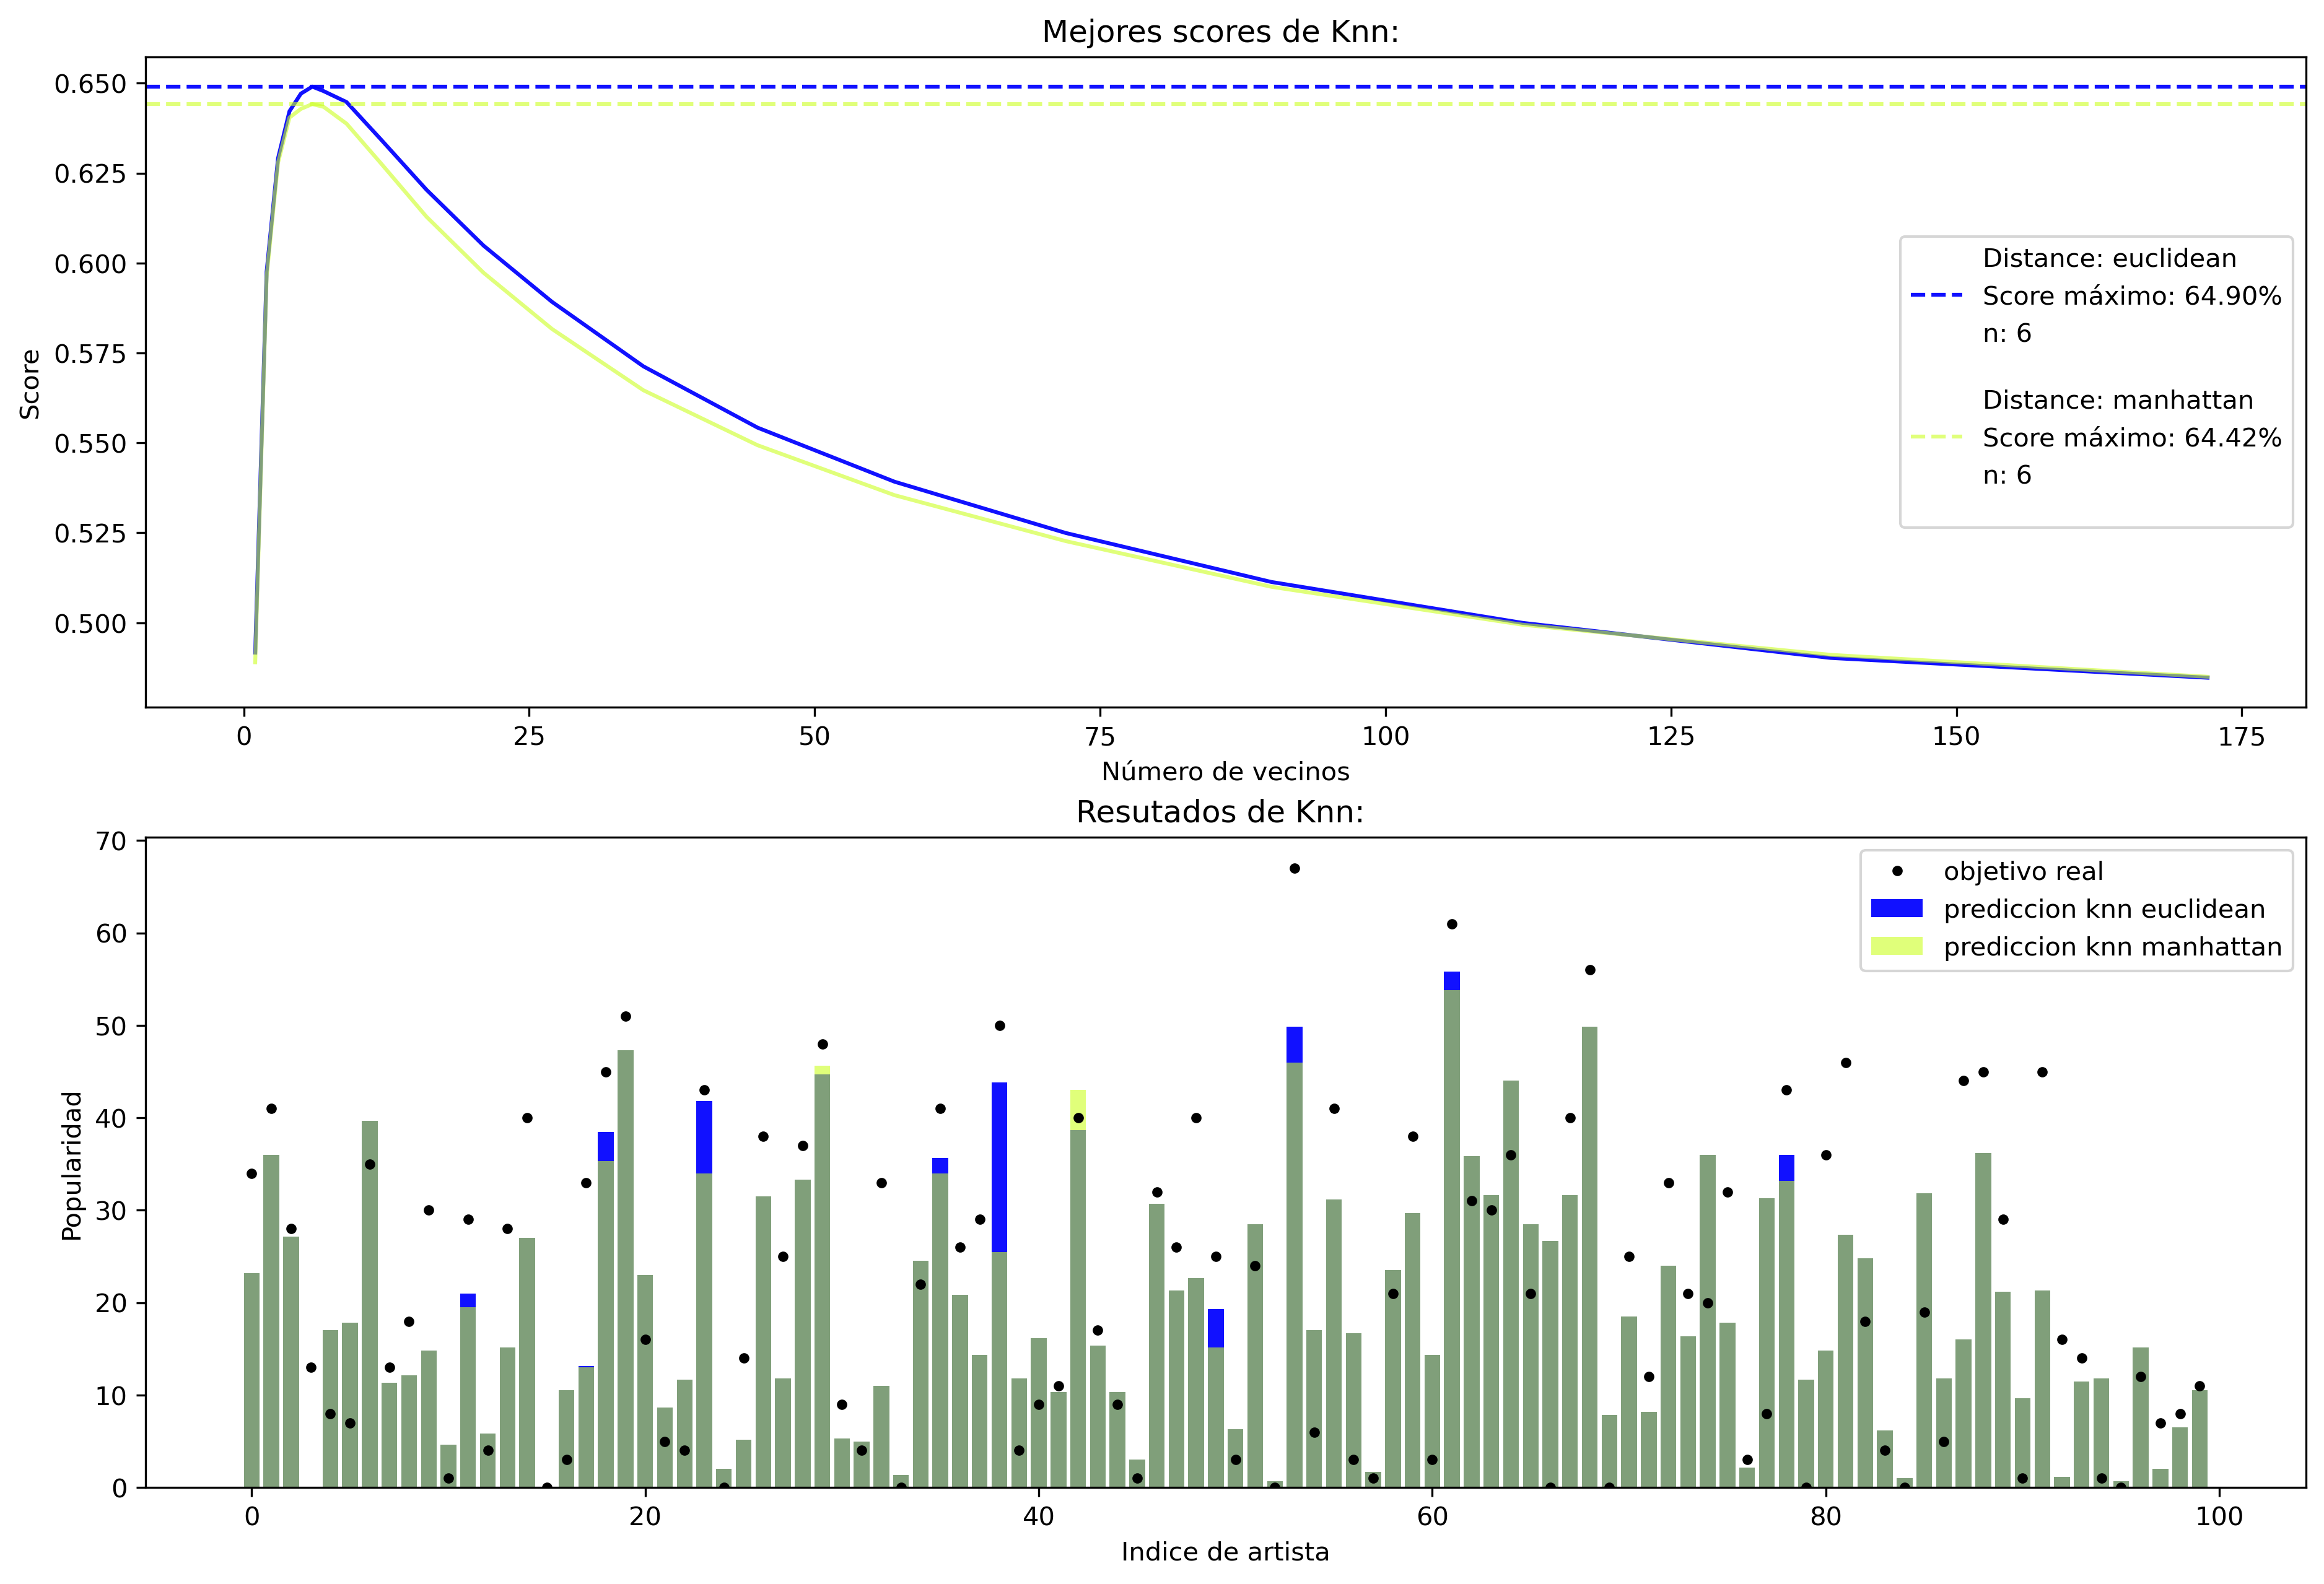

In [226]:
plotScores(scores)

explicar diferencias distancia euclidea y hamming